In [1]:
import operator
# https://github.com/DEAP/deap/issues/491
import gym
import numpy as np
from deap import algorithms, base, creator, gp, tools
from scoop import futures
import pygraphviz as pgv
import matplotlib.pyplot as plt
import math
import imageio

def print_img(img):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.show()

In [2]:
TARGET_EMOJI = 0 #@param "🦎"
vision = 1
tests_for_each_tree = 1
n_total_steps = 10
pset = gp.PrimitiveSet("MAIN", (vision+2)**2) 

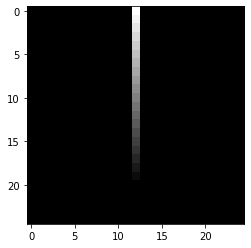

In [3]:
target_img = np.zeros((25,25))
for i in range(25):
    target_img[i][12] = 1 - (i*5)/100

# target_img = load_emoji(TARGET_EMOJI)
print_img(target_img)

In [15]:
############################################ Image functions ################################################
def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[..., :3], to_alpha(x)
    return np.clip(1.0-a+rgb, 0, 0.9999)

def to_alpha(x):
    return np.clip(x[..., 3:4], 0, 0.9999)

def to_gray(x):
    rgb = to_rgb(x)
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def load_emoji(index, path="data/emoji.png"):
    im = imageio.imread(path)
    emoji = np.array(im[:, index*40:(index+1)*40].astype(np.float32))
    emoji /= 255.0
    gray_emoji = to_gray(emoji)
    return gray_emoji

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()

def create_base_env(target_image):
    env = np.copy(target_image)
    env = np.pad(np.copy(target_image), 1)
    env[:] = 1.0
    a, b = env.shape
    env[int(a/2)][int(b/2)] = 0.5
    return env
    
def draw_graph(expr):
    nodes, edges, labels = gp.graph(expr)
    g = pgv.AGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    g.layout(prog="dot")

    for i in nodes:
        n = g.get_node(i)
        n.attr["label"] = labels[i]
    g.draw('out.png')

In [5]:
# Adding functions
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.abs, 1)


def protected_div(a, b):
    if b == 0:
        return 1
    else: 
        return a/b
    
def limit(input, minimum, maximum):
    if input < minimum:
        return minimum
    elif input > maximum:
        return maximum
    else:
        return input

def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

pset.addPrimitive(protected_div, 2)
pset.addPrimitive(limit, 3)
pset.addPrimitive(if_then_else, 3)
# Adding constants
pset.addTerminal(0)
pset.addTerminal(1)
pset.addTerminal(0.1)
pset.addTerminal(255)

In [6]:
############################################ Automata  ################################################

class CA_2D_model:
    def __init__(self, length, width, individual, *, vision=1 ):
        self.individual = individual
        self.len = length + 2*vision
        self.wid = width + 2*vision
        self.vision = vision

        # The size of the pad is dependent on how far each cell sees to updates its valus
        self.original = np.pad(np.zeros((length, width)),1)
        self.original[:] = 255    
        self.original[int(self.len/2)][int(self.wid/2)] = 0

        self.ca = np.copy(self.original)
    
    def reset_ca(self):
        self.ca = np.copy(self.original)

    def new_cell_value(self, i, j):
        if i-self.vision < 0 or j-self.vision < 0:
            return
        if i+self.vision >= self.len or j + self.vision >= self.wid:
            return

        observation = []
        for x in range(i-self.vision, i+self.vision+1):
            for y in range(j-self.vision, j+self.vision+1):
#                 if not (x == i and y == j):
                observation.append(self.ca[x, y])
        return self.individual(*observation)

    def update(self):
        new_ca = np.copy(self.ca)
        for i in range(self.vision, self.len - self.vision): # skipping pad
            for j in range(self.vision, self.wid - self.vision): # skipping pad
                new_ca[i, j] = self.new_cell_value(i, j)
        self.ca = new_ca

    def remove_pad(self):
        return self.ca[self.vision:self.len - self.vision, self.vision:self.wid - self.vision]

    def loss(self, target_image):
        ca = self.remove_pad()
        if target_image.shape != ca.shape:
            raise
        loss = 0
        for i in range(target_image.shape[0]):
            for j in range(target_image.shape[1]):
                if ca[i,j] > 1 or ca[i,j] < 0 or math.isnan(ca[i,j]):
                    return 100
                l = ca[i,j] - target_image[i,j]
                loss += l**2
        return loss

In [7]:
def eval_individual(individual, render=False):
    shape = target_img.shape
    calc_action = toolbox.compile(individual)
    ca = CA_2D_model(shape[0], shape[1], calc_action)
    
    total_loss = 0.0
    for i in range(tests_for_each_tree):
        ca.reset_ca()

        for _ in range(n_total_steps):
            ca.update()

        loss = ca.loss(target_img)
        total_loss += loss  

    
    l = total_loss / tests_for_each_tree
    return (l,)

In [8]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Tree generator
toolbox.register("tree_generator", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.tree_generator)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [9]:
#toolbox.register("map", futures.map)
toolbox.register("evaluate", eval_individual)
toolbox.register("select", tools.selTournament, tournsize=7)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [12]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.2, 30, stats=mstats,
                               halloffame=hof, verbose=True)
draw_graph(hof[0])
eval_individual(hof[0], True)

/tmp/ipykernel_25580/735661410.py:12: RuntimeWarning: overflow encountered in double_scalars
  return a/b
/tmp/ipykernel_25580/735661410.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return a/b


KeyboardInterrupt: 

In [16]:
aux = create_base_env(target_img)
print(aux)

[[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1